# **Importing Libraries**

In [1]:
# Import the needed Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from imageio import imread
from skimage.transform import resize
import datetime
import os

# Supress all the warnings
import warnings
warnings.filterwarnings('ignore')

# Import the random seed and tensorflow
np.random.seed(30)
import random as rn
rn.seed(30)
import tensorflow as tf
tf.random.set_seed(30)
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Flatten, TimeDistributed, BatchNormalization, Activation, Dropout, SimpleRNN, Conv2D, MaxPooling2D
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras import optimizers


# **Loading the Data**

> In this process, this where we learn what's the dataset in consists of as well forming it into dimensions. 

In [2]:
project_folder=r'C:\Users\Rahul\Desktop\Thumbs_up_and_down_Dataset'
read = pd.read_csv(r"C:\Users\Rahul\Desktop\Thumbs_up_and_down_Dataset\train.csv", dtype=object)
print(read.shape)
print(read.info())

(259, 1)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 259 entries, 0 to 258
Data columns (total 1 columns):
 #   Column                                                       Non-Null Count  Dtype 
---  ------                                                       --------------  ----- 
 0   WIN_20180925_17_34_05_Pro_Thumbs_Down_new;Thumbs_Down_new;0  259 non-null    object
dtypes: object(1)
memory usage: 2.2+ KB
None


# **Generator**

> For train_doc and val_doc, it takes random lists of files in train.csv and val.csv to for when training CNN+RNN model. 

In [3]:
## Let us take the Input in to Train and Val doc and Iniatise the Bath size as 10 first and then we train the model
train_doc = np.random.permutation(open(r"C:\Users\Rahul\Desktop\Thumbs_up_and_down_Dataset\train.csv").readlines())
val_doc = np.random.permutation(open(r"C:\Users\Rahul\Desktop\Thumbs_up_and_down_Dataset\val.csv").readlines())
batch_size = 10 #experiment with the batch size

> In this generator function below,there's  a dataset full of videos. The goal is to try to feed the batches of images from videos. What the function is essentially trying to do is ,from each video , to take x amount of images. For each images, they will be resize to the the number we initialize y and z. Then the images are stored inside the batch size (file). From this batch, each images are double checked if each one of them are in the same dimensions. If not, neural network will consider as an input error. If the two images are in different dimensions, the function will crop and resize the images. Once the whole process is done, the images are stored in another file to use for training the model. 

In [4]:
from imageio import imread
import numpy as np
import os
from skimage.transform import resize

channels = 3  # RGB as 3D Convlution
classes = 2
x = 30  # No. of frames images
y = 120  # Width of the image
z = 120  # height

def generator_1(source_path, folder_list, batch_size):
    print('Source path = ', source_path, '; batch size =', batch_size)
    img_idx = [x for x in range(0, x)]  # create a list of image numbers you want to use for a particular video
    while True:
        t = np.random.permutation(folder_list)
        num_batches = len(folder_list) // batch_size  # calculate the number of batches
        for batch in range(num_batches):  # we iterate over the number of batches
            batch_data = np.zeros((batch_size, x, y, z, channels))  # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((batch_size, classes))  # batch_labels is the one hot representation of the output
            for folder in range(batch_size):  # iterate over the batch_size
                imgs = os.listdir(source_path + '/' + t[folder + (batch * batch_size)].split(';')[0])  # read all the images in the folder
                for idx, item in enumerate(img_idx):  # Iterate over the frames/images of a folder to read them in
                    image = imread(source_path + '/' + t[folder + (batch * batch_size)].strip().split(';')[0] + '/' + imgs[item]).astype(np.float32)

                    # crop the images and resize them. Note that the images are of 2 different shapes
                    # and the conv3D will throw an error if the inputs in a batch have different shapes
                    # Let us resize all the images
                    temp_img = resize(image, (y, z))
                    temp_img = temp_img.mean(axis=-1, keepdims=True)  # Convert to grayscale
                    temp_img = temp_img / 255.0  # Normalize data

                    batch_data[folder, idx] = temp_img  # Normalize and feed in the image

                batch_labels[folder, int(t[folder + (batch * batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels  # you yield the batch_data and the batch_labels, remember what does yield do

        # write the code for the remaining data points which are left after full batches.

        if len(folder_list) != batch_size * num_batches:
            print("Batches: ", num_batches + 1, "Index:", batch_size)
            batch_size = len(folder_list) - (batch_size * num_batches)
            batch_data = np.zeros((batch_size, x, y, z, channels))  # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((batch_size, classes))  # batch_labels is the one hot representation of the output
            for folder in range(batch_size):  # iterate over the batch_size
                imgs = os.listdir(source_path + '/' + t[folder + (batch * batch_size)].split(';')[0])  # read all the images in the folder
                for idx, item in enumerate(img_idx):  # Iterate over the frames/images of a folder to read them in
                    image = imread(source_path + '/' + t[folder + (batch * batch_size)].strip().split(';')[0] + '/' + imgs[item]).astype(np.float32)

                    # crop the images and resize them. Note that the images are of 2 different shapes
                    # and the conv3D will throw an error if the inputs in a batch have different shapes
                    temp_img = resize(image, (y, z))
                    temp_img = temp_img.mean(axis=-1, keepdims=True)  # Convert to grayscale
                    temp_img = temp_img / 255.0  # Normalize data

                    batch_data[folder, idx] = temp_img

                batch_labels[folder, int(t[folder + (batch * batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels


> This function below is try to count how many videos are currently in train.csv and how many are in in val.csv. 

In [5]:
curr_dt_time = datetime.datetime.now()
train_path = r"C:\Users\Rahul\Desktop\Thumbs_up_and_down_Dataset\Train"
val_path = r"C:\Users\Rahul\Desktop\Thumbs_up_and_down_Dataset\Val"
num_train_sequences = len(train_doc)
print('# Training_Sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# Validation_Sequences =', num_val_sequences)
num_epochs = 40 # choose the number of epochs
print ('# Epochs = ', num_epochs)

# Training_Sequences = 260
# Validation_Sequences = 37
# Epochs =  40


# **Building CNN+RNN Model**

In [6]:


CNNRNN_Model = Sequential()   

CNNRNN_Model.add(TimeDistributed(Conv2D(16, (3, 3) , padding='same', activation='relu'),input_shape=(x,y,z,3)))
CNNRNN_Model.add(TimeDistributed(BatchNormalization()))
CNNRNN_Model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
CNNRNN_Model.add(TimeDistributed(Conv2D(32, (3, 3) , padding='same', activation='relu')))
CNNRNN_Model.add(TimeDistributed(BatchNormalization()))
CNNRNN_Model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
CNNRNN_Model.add(TimeDistributed(Conv2D(64, (3, 3) , padding='same', activation='relu')))
CNNRNN_Model.add(TimeDistributed(BatchNormalization()))
CNNRNN_Model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
CNNRNN_Model.add(TimeDistributed(Conv2D(128, (3, 3) , padding='same', activation='relu')))
CNNRNN_Model.add(TimeDistributed(BatchNormalization()))
CNNRNN_Model.add(TimeDistributed(MaxPooling2D((2, 2))))

# Flatten layer 

CNNRNN_Model.add(TimeDistributed(Flatten()))
CNNRNN_Model.add(SimpleRNN(64))
CNNRNN_Model.add(Dropout(0.25))

# Dense layer 
CNNRNN_Model.add(Dense(64,activation='relu'))
CNNRNN_Model.add(Dropout(0.25))
# Softmax layer

CNNRNN_Model.add(Dense(2, activation='softmax'))

# Adam optimiser

optimiser = optimizers.Adam(lr=0.0001) #write your optimizer
CNNRNN_Model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (CNNRNN_Model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed (TimeDist  (None, 30, 120, 120, 16   448       
 ributed)                    )                                   
                                                                 
 time_distributed_1 (TimeDi  (None, 30, 120, 120, 16   64        
 stributed)                  )                                   
                                                                 
 time_distributed_2 (TimeDi  (None, 30, 60, 60, 16)    0         
 stributed)                                                      
                                                                 
 time_distributed_3 (TimeDi  (None, 30, 60, 60, 32)    4640      
 stributed)                                                      
                                                                 
 time_distributed_4 (TimeDi  (None, 30, 60, 60, 32)    1

In [7]:
# Let us train and validate the model 
train_generator = generator_1(train_path, train_doc, batch_size)
val_generator = generator_1(val_path, val_doc, batch_size)

In [8]:
# Let us see the Validate the Losses and put back the checkpoint

model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, cooldown=1, verbose=1) # write the REducelronplateau code here
callbacks_list = [checkpoint, LR]

In [9]:
# Let us see that the steps_per_epoch and validation steps are used by fit to decide the no. of next()

if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [10]:
history = CNNRNN_Model.fit(train_generator, steps_per_epoch = steps_per_epoch, epochs=20, verbose=1,
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  C:\Users\Rahul\Desktop\Thumbs_up_and_down_Dataset\Train ; batch size = 10
Epoch 1/20



26/26 [==============================] - ETA: 0s - loss: 0.8060 - categorical_accuracy: 0.5692Source path =  C:\Users\Rahul\Desktop\Thumbs_up_and_down_Dataset\Val ; batch size = 10
Batches:  4 Index: 10

Epoch 1: saving model to model_init_2024-01-2713_55_04.633886\model-00001-0.80602-0.56923-0.75371-0.40541.h5
26/26 [==============================] - 59s 2s/step - loss: 0.8060 - categorical_accuracy: 0.5692 - val_loss: 0.7537 - val_categorical_accuracy: 0.4054 - lr: 0.0010
Epoch 2/20
26/26 [==============================] - ETA: 0s - loss: 0.5882 - categorical_accuracy: 0.6923Batches:  6 Index: 7

Epoch 2: saving model to model_init_2024-01-2713_55_04.633886\model-00002-0.58823-0.69231-0.63571-0.71429.h5
26/26 [==============================] - 50s 2s/step - loss: 0.5882 - categorical_accuracy: 0.6923 - val_loss: 0.6357 - val_categorical_accuracy: 0.7143 - lr: 0.0010
Epoch 3/20
26/26 [==============================] - ETA: 0s - loss: 0.4357 - categorical_accuracy: 0.7962
Epoch 3: savi

In [14]:
val_accuracy = np.mean(history.history['val_categorical_accuracy'])
print("\n%s: %.2f%%" % ('Validation Accuracy', val_accuracy*100))


Validation Accuracy: 66.76%


# **Training And Validation Loss Over Epochs**

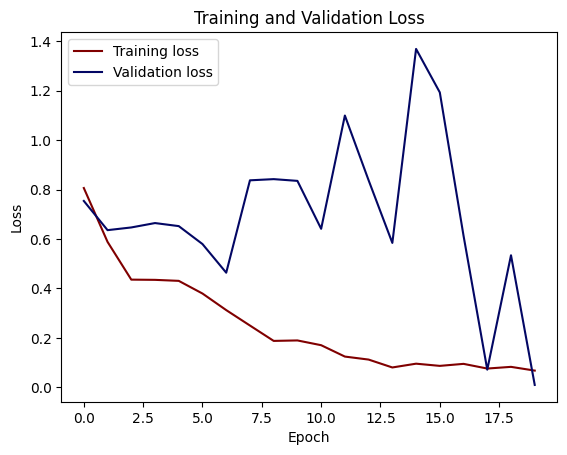

In [15]:
import matplotlib.pyplot as plt


history_df = pd.DataFrame(history.history)
plt.plot(history_df.loc[:, ['loss']], "#800000", label='Training loss')
plt.plot(history_df.loc[:, ['val_loss']], "#030764", label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# **Training And Validation Accuracy Over Epochs**

In [13]:
history_df = pd.DataFrame(history.history)

plot.plot(history_df.loc[:, ['categorical_accuracy']], "#800000", label='Training accuracy')
plot.plot(history_df.loc[:, ['val_categorical_accuracy']], "#030764", label='Validation accuracy')

plot.title('Training and Validation Accuracy')
plot.xlabel('Epochs')
plot.ylabel('Accuracy')

plot.legend()
plot.show()

NameError: name 'plot' is not defined

# **Same CNN+RNN Model with Different Image's Size (30X30)**

In [ ]:
x = 30 # number of frames
y = 30 # image width
z = 30 # image height

CNNRNN_Model2 = Sequential()   

CNNRNN_Model2.add(TimeDistributed(Conv2D(16, (3, 3) , padding='same', activation='relu'),input_shape=(x,y,z,3)))
CNNRNN_Model2.add(TimeDistributed(BatchNormalization()))
CNNRNN_Model2.add(TimeDistributed(MaxPooling2D((2, 2))))
        
CNNRNN_Model2.add(TimeDistributed(Conv2D(32, (3, 3) , padding='same', activation='relu')))
CNNRNN_Model2.add(TimeDistributed(BatchNormalization()))
CNNRNN_Model2.add(TimeDistributed(MaxPooling2D((2, 2))))
        
CNNRNN_Model2.add(TimeDistributed(Conv2D(64, (3, 3) , padding='same', activation='relu')))
CNNRNN_Model2.add(TimeDistributed(BatchNormalization()))
CNNRNN_Model2.add(TimeDistributed(MaxPooling2D((2, 2))))
        
CNNRNN_Model2.add(TimeDistributed(Conv2D(128, (3, 3) , padding='same', activation='relu')))
CNNRNN_Model2.add(TimeDistributed(BatchNormalization()))
CNNRNN_Model2.add(TimeDistributed(MaxPooling2D((2, 2))))

# Flatten layer 

CNNRNN_Model2.add(TimeDistributed(Flatten()))

CNNRNN_Model2.add(SimpleRNN(64))
CNNRNN_Model2.add(Dropout(0.25))

# Dense layer 
CNNRNN_Model2.add(Dense(64,activation='relu'))
CNNRNN_Model2.add(Dropout(0.25))
# Softmax layer

CNNRNN_Model2.add(Dense(5, activation='softmax'))

# Adam optimiser

optimiser = optimizers.Adam(lr=0.001) #write your optimizer
CNNRNN_Model2.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (CNNRNN_Model2.summary())

In [ ]:
train_generator = generator_1(train_path, train_doc, batch_size)
val_generator = generator_1(val_path, val_doc, batch_size)

In [ ]:
history1 = CNNRNN_Model2.fit(train_generator, steps_per_epoch = steps_per_epoch, epochs=40, verbose=1,
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

In [ ]:
val_accuracy = np.mean(history1.history['val_categorical_accuracy'])
print("\n%s: %.2f%%" % ('Validation Accuracy', val_accuracy*100))

# **Training And Validation Loss Over Epochs (Image's Size 30X30)**

In [ ]:
history_df = pd.DataFrame(history1.history)
plot.plot(history_df.loc[:, ['loss']], "#800000", label='Training loss')
plot.plot(history_df.loc[:, ['val_loss']],"#030764", label='Validation loss')
plot.title('Training and Validation Loss')
plot.xlabel('Epochs')
plot.ylabel('Loss')

plot.legend(loc="best")
plot.show()

# **Training And Validation Accuracy Over Epochs (Image's Size 30X30)**

In [ ]:
history_df = pd.DataFrame(history1.history)

plot.plot(history_df.loc[:, ['categorical_accuracy']], "#800000", label='Training accuracy')
plot.plot(history_df.loc[:, ['val_categorical_accuracy']], "#030764", label='Validation accuracy')

plot.title('Training and Validation Accuracy')
plot.xlabel('Epochs')
plot.ylabel('Accuracy')

plot.legend()
plot.show()